# Learning Theory from First Principles

## Chapter 8 : Sparse methods

### Generic packages, settings and helper functions



#### Packages

In [ ]:
from google.colab import files
import numpy as np
from numpy.random import randn, rand
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from scipy.stats import ortho_group
from scipy.special import erfinv, gamma
from scipy.linalg import sqrtm, eigh
from bisect import bisect
import tqdm
import warnings

np.random.seed(seed=1)

#### Settings

The code below is used to standardize the appearance of the graphics. The graphs may appear unevenly sized when displayed in this notebook, but once downloaded they are the correct size.

In [ ]:
# Appearance of the graphs

# adujst font
SMALL_FONT = 5
MED_FONT = 8
BIG_FONT = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_FONT
mpl.rcParams['axes.titlesize'] = SMALL_FONT

# adujst lines and markers
mpl.rcParams['axes.linewidth'] = .3
mpl.rcParams['lines.linewidth'] = .7
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['patch.linewidth'] = .3
mpl.rcParams['errorbar.capsize'] = 1.5
mpl.rcParams['lines.markeredgewidth'] = .3

# withdraw the ticks
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0

# adjust legend box
mpl.rcParams['legend.fancybox'] = 0
mpl.rcParams['legend.shadow'] = 0
mpl.rcParams['legend.framealpha'] = 1

# adjust fig general settings
mpl.rcParams['figure.dpi'] = 600

big_rectangle = (6.5, 3.5) # height = 9 cm, width = 17 cm
medium_rectangle = (4.7, 1.6) # height = 4 cm, width = 12 cm
medium_square = (4.7, 4.7) # height = 12 cm, width = 12 cm
small_rectangle = (2.4, 1.6) # height = 6 cm, width = 4 cm
mpl.rcParams['figure.figsize'] = small_rectangle

inner_space = {'wspace':.5, 'hspace':.5}

# savefig params
mpl.rcParams["savefig.bbox"] = 'tight'

#### Helper functions

In [ ]:
def mse(y_hat, y):
  return np.mean((y - y_hat)**2)

zero_one = np.vectorize(lambda u: 1 if u<0 else 0)
hinge = np.vectorize(lambda u: np.maximum(1-u, 0))
square = np.vectorize(lambda u: (1-u)**2)
logis = np.vectorize(lambda u: np.log(1+np.exp(-u)))

### Figures


#### Fig 8.1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

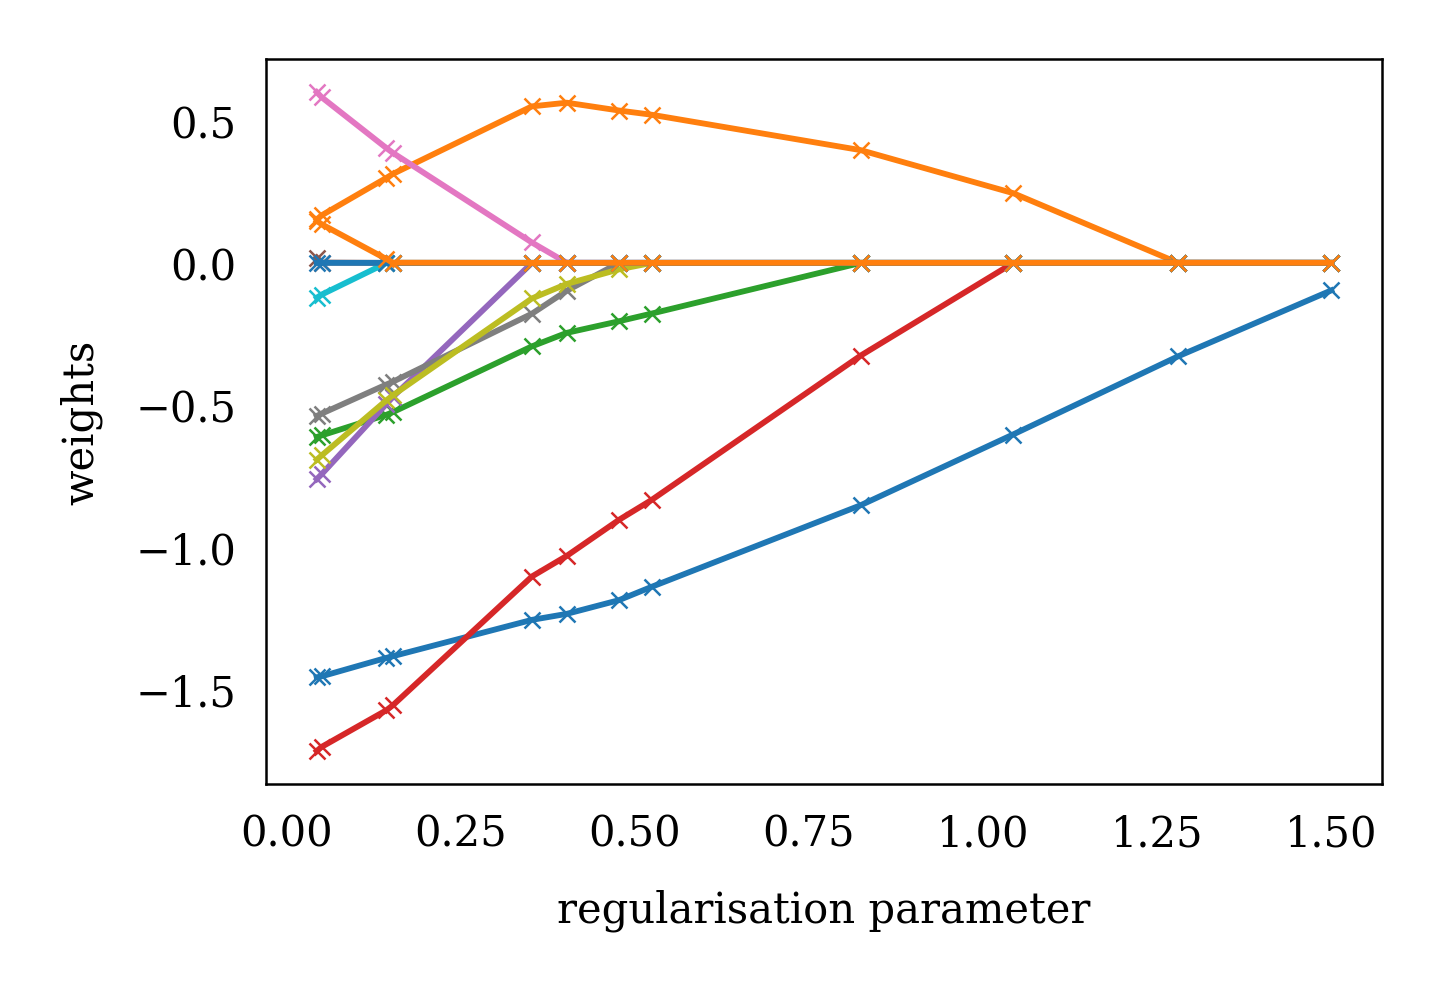

In [ ]:
n = 32
d = 12
k = 4
sd_noise = 1
X = np.random.randn(n, d)
wast = np.zeros(d)
wast[0:k] = np.sign(np.random.randn(k))
y = X.dot(wast) + sd_noise*np.sqrt(k)*np.random.randn(n)

#Lasso
w = np.zeros(d)
LAMBDAS = np.arange(0, 1.5005, 0.0005)
L = np.max(np.linalg.eigvals(X.T.dot(X)/n))

ws = np.zeros((len(LAMBDAS), d))
for il in range(len(LAMBDAS)):
    lmbd = LAMBDAS[il]
    maxit = 200
    for iter in range(maxit):
        grad = (1/n)*X.T.dot(X.dot(w)-y)
        w = w - (1/L)*grad
        w = np.sign(w) * np.maximum(np.abs(w)  - lmbd/L, 0)
    ws[il, ] = w

nactive = np.sum(np.abs(ws)>1e-4, axis=1)
ind = list(np.where(np.abs(nactive[1:] - nactive[:-1])>0)[0])
ind.append(len(LAMBDAS)-1)


plt.figure(figsize = small_rectangle)
plt.plot(LAMBDAS[ind], ws[ind], '-x')
plt.xlabel('regularisation parameter')
plt.ylabel('weights');

plt.savefig('fig81.svg')
files.download("fig81.svg")

### Fig 8.2

In [ ]:
def script_model_selection(n,d,k,std_noise,seeds,dmax):

    nrep = len(seeds)
    lambdas = 10**np.arange(1, -7, -0.1)

    performance_lasso = np.zeros((len(lambdas), nrep))
    performance_ridge = np.zeros((len(lambdas), nrep))
    performance_OMP = np.zeros((d, nrep))
    performance_oracle = np.zeros(nrep)
    performance_zero = np.zeros(nrep)

    for iseed in range(nrep):
        seed = seeds[iseed]
        np.random.seed(seed)

        X = np.random.randn(n, dmax)
        X = X[:, :d]
        wast = np.zeros(d)
        wast[0:k] = np.sign(np.random.randn(k))
        y = X @ wast + std_noise * np.sqrt(k) * np.random.randn(n)

        # zero prediction
        w = np.zeros(d)
        performance_zero[iseed] = np.mean((X @ (w - wast))**2)

        # lasso
        w = np.zeros(d)
        L = np.max(np.linalg.eig(X.T @ X/n)[0])
        ws = np.zeros((d, len(lambdas)))
        vals = np.zeros(len(lambdas))

        for ilambda in range(len(lambdas)):
            lambda_ = lambdas[ilambda]
            maxiter = 20
            for iter_ in range(maxiter):
                grad = 1/n * X.T @ (X @ w - y)
                w = w - 1/L * grad
                w = np.sign(w) * np.maximum(np.abs(w) - lambda_/L, 0)

            ws[:, ilambda] = w
            vals[ilambda] = np.mean((X @ (w - wast))**2)

        performance_lasso[:, iseed] = vals

        # ridge
        w = np.zeros((d, 1))
        vals = np.zeros(len(lambdas))

        for ilambda in range(len(lambdas)):
            lambda_ = lambdas[ilambda]
            w_ridge = np.linalg.inv(X.T @ X + n*lambda_*np.eye(d)) @ (X.T @ y)
            vals[ilambda] = np.sum(1/n * (X @ (w_ridge - wast))**2)

        performance_ridge[:, iseed] = vals

        # omp
        I = []
        Ic = np.arange(d)
        vals_OMP = np.zeros(d)
        Xorth = X.copy()
        yorth = y.copy()

        for i in range(d):
            perfloc = np.zeros(len(Ic))
            for j in range(len(Ic)):
                icand = Ic[j]
                wcand = (Xorth[:, icand].T @ Xorth[:, icand] + n*1e-14) / (Xorth[:, icand].T @ yorth)
                perfloc[j] = np.mean((Xorth[:, icand] * wcand - yorth)**2)

            b = np.argmin(perfloc)
            I.append(Ic[b])
            inew = Ic[b]
            Ic = np.delete(Ic, b)
            wcand = np.linalg.solve(X[:, I].T @ X[:, I] + n * 1e-12 * np.eye(i+1), X[:, I].T @ y)
            w = np.zeros(d)
            w[I] = wcand
            vals_OMP[i] = np.mean((X @ (w - wast))**2)
            temp = (np.eye(n) - Xorth[:, inew] @ Xorth[:, inew].T / (Xorth[:, inew].T @ Xorth[:, inew] + n * 1e-14))
            Xorth = temp @ Xorth
            yorth = temp @ yorth

        performance_OMP[:, iseed] = vals_OMP

        w_ols = np.linalg.solve(X.T @ X + n*1e-14*np.eye(d), X.T @ y)
        performance_ols = np.mean((X @ (w_ols - wast))**2)
        I = np.arange(k)
        wcand = np.linalg.solve(X[:, I].T @ X[:, I] + n*1e-12*np.eye(k), X[:, I].T @ y)
        w = np.zeros(d)
        w[I] = wcand
        performance_oracle[iseed] = np.mean((X @ (w - wast))**2)

    return performance_lasso, performance_ridge, performance_OMP, performance_oracle, performance_zero


In [ ]:
def script_model_selectionROT(n,d,k,std_noise,seeds,dmax):

    nrep = len(seeds)
    lambdas = 10**np.arange(1, -7, -0.1)

    performance_lasso = np.zeros((len(lambdas), nrep))
    performance_ridge = np.zeros((len(lambdas), nrep))
    performance_OMP = np.zeros((d, nrep))

    for iseed in range(nrep):
        seed = seeds[iseed]
        np.random.seed(seed)

        X = np.random.randn(n, dmax)
        X = X[:, :d]
        wast = np.zeros(d)
        wast[0:k] = np.sign(np.random.randn(k))
        y = X @ wast + std_noise * np.sqrt(k) * np.random.randn(n)

        # random rotation
        u, s, v = np.linalg.svd(np.random.randn(d, d))
        X = X @ u
        wast = u.T @ wast

        # lasso
        w = np.zeros(d)
        L = np.max(np.linalg.eig(X.T @ X/n)[0])
        ws = np.zeros((d, len(lambdas)))
        vals = np.zeros(len(lambdas))

        for ilambda in range(len(lambdas)):
            lambda_ = lambdas[ilambda]
            maxiter = 20
            for iter_ in range(maxiter):
                grad = 1/n * X.T @ (X @ w - y)
                w = w - 1/L * grad
                w = np.sign(w) * np.maximum(np.abs(w) - lambda_/L, 0)

            ws[:, ilambda] = w
            vals[ilambda] = np.mean((X @ (w - wast))**2)

        performance_lasso[:, iseed] = vals

        # ridge
        w = np.zeros((d, 1))
        vals = np.zeros(len(lambdas))

        for ilambda in range(len(lambdas)):
            lambda_ = lambdas[ilambda]
            w_ridge = np.linalg.inv(X.T @ X + n*lambda_*np.eye(d)) @ (X.T @ y)
            vals[ilambda] = np.sum(1/n * (X @ (w_ridge - wast))**2)

        performance_ridge[:, iseed] = vals

        # omp
        I = []
        Ic = np.arange(d)
        vals_OMP = np.zeros(d)
        Xorth = X.copy()
        yorth = y.copy()

        for i in range(d):
            perfloc = np.zeros(len(Ic))
            for j in range(len(Ic)):
                icand = Ic[j]
                wcand = (Xorth[:, icand].T @ Xorth[:, icand] + n*1e-14) / (Xorth[:, icand].T @ yorth)
                perfloc[j] = np.mean((Xorth[:, icand] * wcand - yorth)**2)

            b = np.argmin(perfloc)
            I.append(Ic[b])
            inew = Ic[b]
            Ic = np.delete(Ic, b)
            wcand = np.linalg.solve(X[:, I].T @ X[:, I] + n * 1e-12 * np.eye(i+1), X[:, I].T @ y)
            w = np.zeros(d)
            w[I] = wcand
            vals_OMP[i] = np.mean((X @ (w - wast))**2)
            temp = (np.eye(n) - Xorth[:, inew] @ Xorth[:, inew].T / (Xorth[:, inew].T @ Xorth[:, inew] + n * 1e-14))
            Xorth = temp @ Xorth
            yorth = temp @ yorth

        performance_OMP[:, iseed] = vals_OMP

        w_ols = np.linalg.solve(X.T @ X + n*1e-14*np.eye(d), X.T @ y)
        performance_ols = np.mean((X @ (w_ols - wast))**2)

    return performance_lasso, performance_ridge, performance_OMP


In [ ]:
n = 64
k = 4
std_noise = 1

ds = np.unique(np.round(2**(np.arange(2, 8.1, 0.1))))
ds = ds.astype(int)
performance_lassos = np.zeros(len(ds))
performance_ridges = np.zeros(len(ds))
performance_OMPs = np.zeros(len(ds))
performance_oracles = np.zeros(len(ds))
performance_zeros = np.zeros(len(ds))

for id in range(len(ds)):
    d = ds[id]
    print(id)
    performance_lasso, performance_ridge, performance_OMP, performance_oracle, performance_zero = script_model_selection(n, d, k, std_noise, np.arange(1, 129), max(ds))
    performance_lassos[id] = np.min(np.mean(performance_lasso, axis=1))
    performance_ridges[id] = np.min(np.mean(performance_ridge, axis=1))
    performance_OMPs[id] = np.min(np.mean(performance_OMP, axis=1))
    performance_oracles[id] = np.mean(performance_oracle)
    performance_zeros[id] = np.mean(performance_zero)

performance_lassosROT = np.zeros(len(ds))
performance_ridgesROT = np.zeros(len(ds))
performance_OMPsROT = np.zeros(len(ds))
performance_oraclesROT = np.zeros(len(ds))

for id in range(len(ds)):
    d = ds[id]
    performance_lassoROT, performance_ridgeROT, performance_OMPROT = script_model_selectionROT(n, d, k, std_noise, np.arange(1, 129), max(ds))
    performance_lassosROT[id] = np.min(np.mean(performance_lassoROT, axis=1))
    performance_ridgesROT[id] = np.min(np.mean(performance_ridgeROT, axis=1))
    performance_OMPsROT[id] = np.min(np.mean(performance_OMPROT, axis=1))
    performance_oraclesROT[id] = np.mean(performance_oracle)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


<ipython-input-5-48d8420b0387>:40: ComplexWarning: Casting complex values to real discards the imaginary part
  ws[:, ilambda] = w
<ipython-input-5-48d8420b0387>:41: ComplexWarning: Casting complex values to real discards the imaginary part
  vals[ilambda] = np.mean((X @ (w - wast))**2)


34
35
36
37


<ipython-input-5-48d8420b0387>:67: RuntimeWarning: overflow encountered in matmul
  wcand = (Xorth[:, icand].T @ Xorth[:, icand] + n*1e-14) / (Xorth[:, icand].T @ yorth)
<ipython-input-5-48d8420b0387>:67: RuntimeWarning: invalid value encountered in double_scalars
  wcand = (Xorth[:, icand].T @ Xorth[:, icand] + n*1e-14) / (Xorth[:, icand].T @ yorth)
<ipython-input-5-48d8420b0387>:78: RuntimeWarning: overflow encountered in matmul
  temp = (np.eye(n) - Xorth[:, inew] @ Xorth[:, inew].T / (Xorth[:, inew].T @ Xorth[:, inew] + n * 1e-14))
<ipython-input-5-48d8420b0387>:78: RuntimeWarning: invalid value encountered in double_scalars
  temp = (np.eye(n) - Xorth[:, inew] @ Xorth[:, inew].T / (Xorth[:, inew].T @ Xorth[:, inew] + n * 1e-14))
<ipython-input-5-48d8420b0387>:68: RuntimeWarning: overflow encountered in square
  perfloc[j] = np.mean((Xorth[:, icand] * wcand - yorth)**2)


38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


<ipython-input-6-cedbdc7a7a32>:39: ComplexWarning: Casting complex values to real discards the imaginary part
  ws[:, ilambda] = w
<ipython-input-6-cedbdc7a7a32>:66: RuntimeWarning: overflow encountered in matmul
  wcand = (Xorth[:, icand].T @ Xorth[:, icand] + n*1e-14) / (Xorth[:, icand].T @ yorth)
<ipython-input-6-cedbdc7a7a32>:66: RuntimeWarning: invalid value encountered in double_scalars
  wcand = (Xorth[:, icand].T @ Xorth[:, icand] + n*1e-14) / (Xorth[:, icand].T @ yorth)
<ipython-input-6-cedbdc7a7a32>:77: RuntimeWarning: overflow encountered in matmul
  temp = (np.eye(n) - Xorth[:, inew] @ Xorth[:, inew].T / (Xorth[:, inew].T @ Xorth[:, inew] + n * 1e-14))
<ipython-input-6-cedbdc7a7a32>:77: RuntimeWarning: invalid value encountered in double_scalars
  temp = (np.eye(n) - Xorth[:, inew] @ Xorth[:, inew].T / (Xorth[:, inew].T @ Xorth[:, inew] + n * 1e-14))
<ipython-input-6-cedbdc7a7a32>:67: RuntimeWarning: overflow encountered in square
  perfloc[j] = np.mean((Xorth[:, icand] * w

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

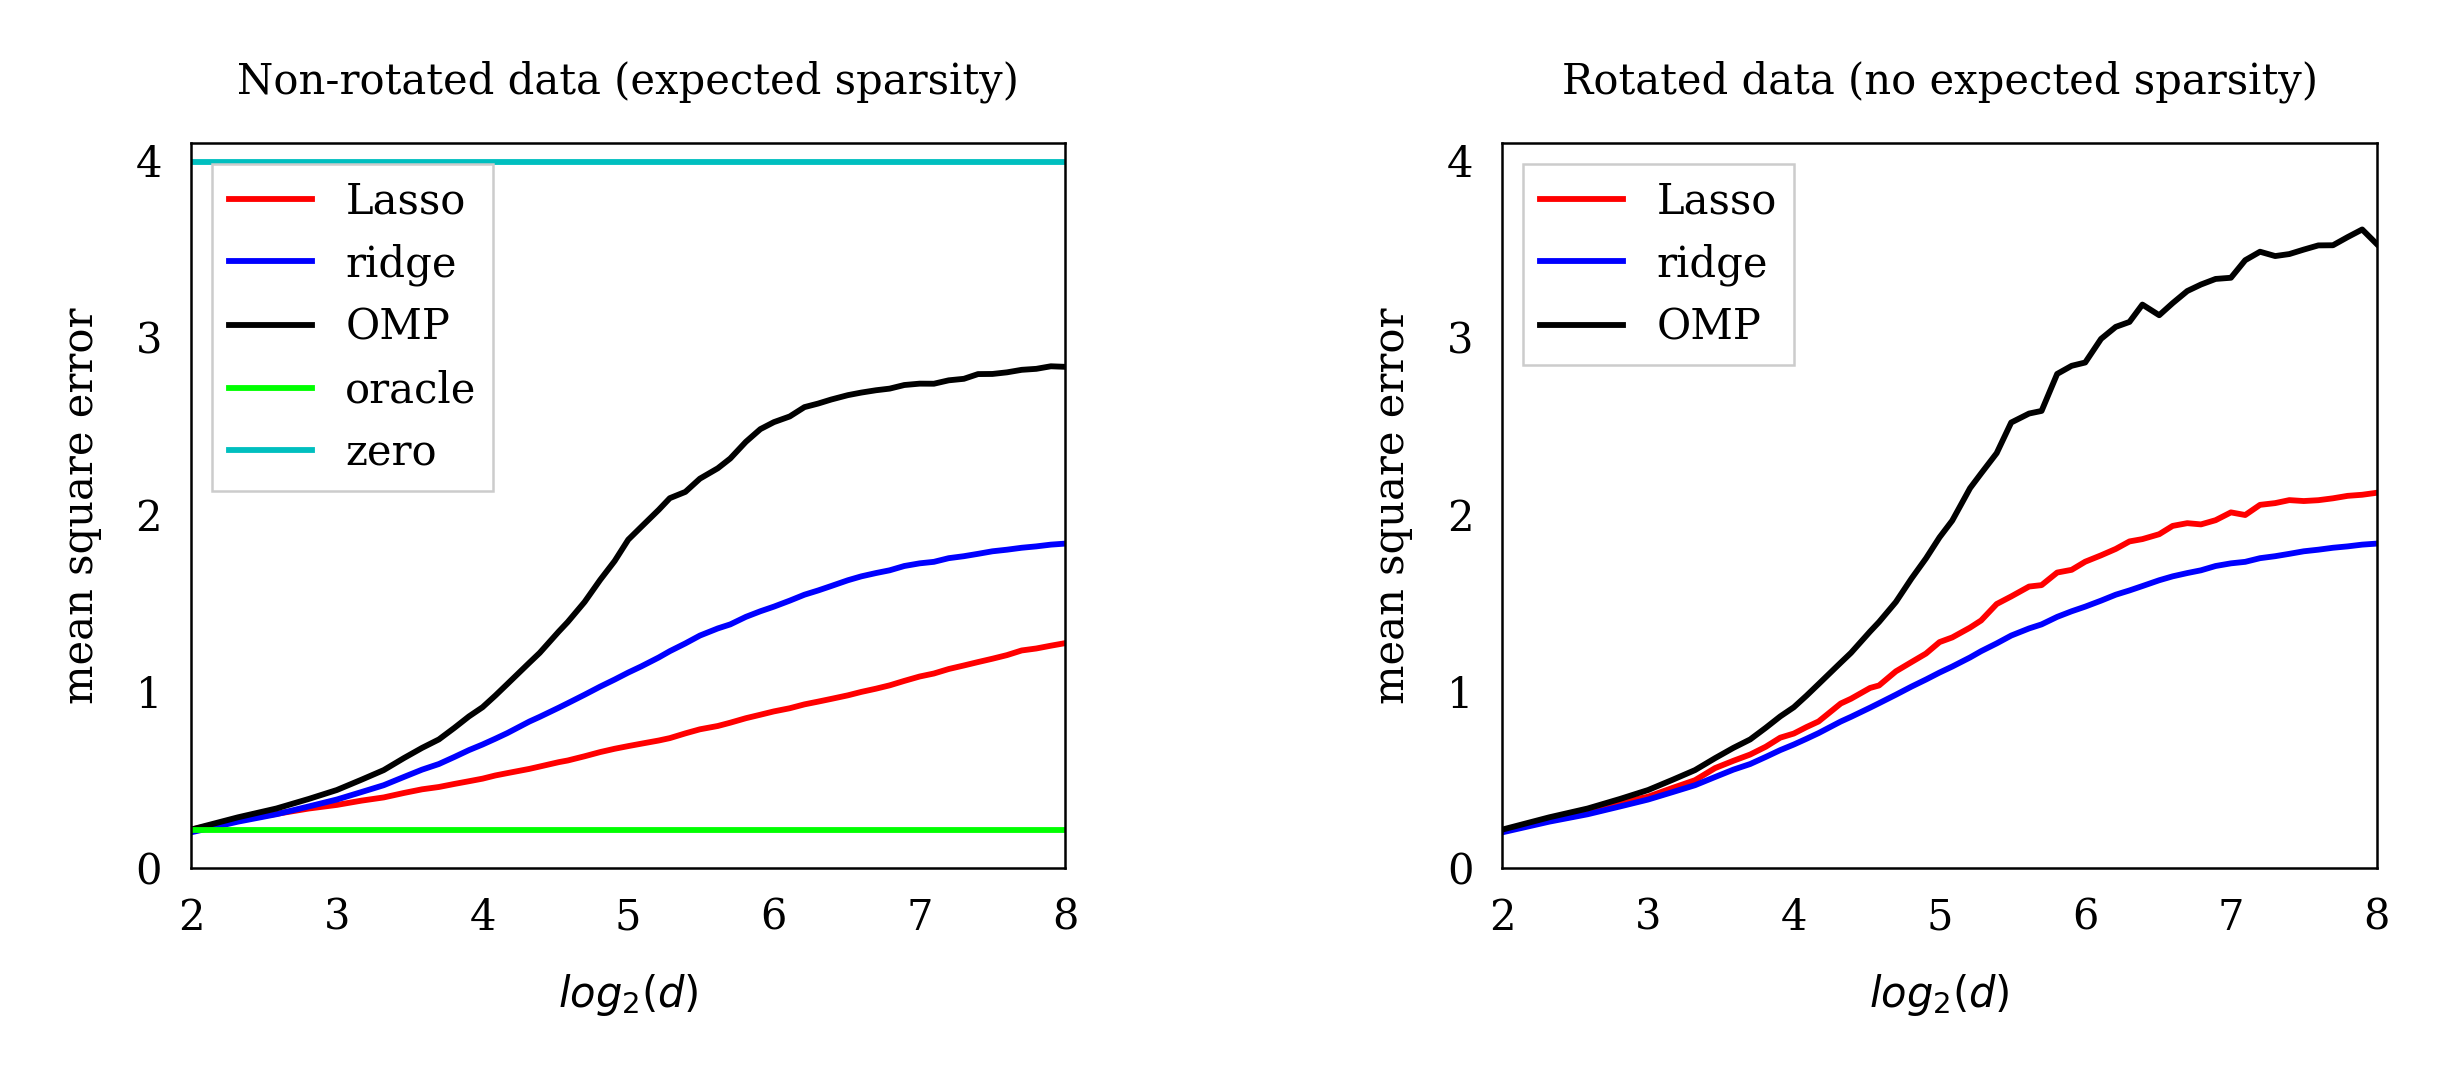

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = medium_rectangle, gridspec_kw = inner_space)

plt.sca(axs[0])
plt.plot(np.log2(ds), performance_lassos, 'r')
plt.plot(np.log2(ds), performance_ridges, 'b')
plt.plot(np.log2(ds), performance_OMPs, 'k')
plt.plot(np.log2(ds), performance_oracles, 'lime')
plt.plot(np.log2(ds), performance_zeros, 'c')
plt.legend(['Lasso', 'ridge', 'OMP', 'oracle', 'zero'], loc='upper left')
plt.xlabel('$log_2(d)$')
plt.ylabel('mean square error')
plt.title('Non-rotated data (expected sparsity)')
plt.axis([2, 8, 0, 4.1])

plt.sca(axs[1])
plt.plot(np.log2(ds), performance_lassosROT, 'r')
plt.plot(np.log2(ds), performance_ridgesROT, 'b')
plt.plot(np.log2(ds), performance_OMPsROT, 'k')
plt.legend(['Lasso', 'ridge', 'OMP'], loc='upper left')
plt.xlabel('$log_2(d)$')
plt.ylabel('mean square error')
plt.title('Rotated data (no expected sparsity)')
plt.axis([2, 8, 0, 4.1])

plt.savefig('fig82.svg')
files.download("fig82.svg")